# Modelling fluid inclusion stretching during stalling
- This notebook shows how to model the stretching of CO2 dominated fluid inclusions in olivine using python tool RelaxiFI (DeVitre and Wieser, 2023; EarthArXiv), implemented in DiadFit. Note that this tool is not designed to model FI with fluids other than CO2 at this time, or those in phases other than olivine. It is based on the model of Wanamaker and Evans, 1989.
- In this example from the RelaxiFI documentation, based on the work from DeVitre and Wieser, 2023 (EarthArXiv), we model the stretching of two CO2 dominated fluid inclusions with 1 and 20 μm radii, trapped at South Caldera Reservoir (Kilaeua volcano, Hawaii) and stored at Halema'uma'u reservoir for 2 years.

## First, make sure CoolProp is installed if using the Span and Wagner 1996 equation of state
- You only need to run this once. If you do not wish to use CoolProp, or face installation problems, please use 'SP94' instead of 'SW96'
- If you have Python installed through Anaconda, you may want to install CoolProp through your conda command line 'conda install conda-forge::coolprop'. Else you can use 'pip install CoolProp' as below. 

In [3]:
#pip install CoolProp

## Next import the necessary packages, including DiadFit

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf

## Now let's model stretching and evaluate how density, pressure and radius change
- We model an FI (5 um) coming from South Caldera (SC) reservoir (4km@ 1300 C) and stalling at Halema'uma'u (HM) reservoir (1km @ 1150 C)


### First, set the PT conditions of the reservoirs

In [5]:
####### Establish reservoir PTX conditions

## Choose an equation of state and crustal density model for the calculations
EOS='SW96'
crustal_model_config=pf.config_crustalmodel(model='ryan_lerner') # this configures the crustal model to be used

## SC reservoir conditions
Trapping_depth = 4 # Average depth of the South Caldera reservoir in km
melt_MgO=13 #melt MgO in wt% 
Trapping_temp=round(21.2*melt_MgO+1017,-1)  # Temperature in C at South Caldera reservoir (MgO thermometry, see DeVitre and Wieser, 2023, Shea 2022)
# find pressure @ SC
tolerance = 0.001 # How close we want to be to the target pressure
Trapping_pressure = pf.find_P_for_kmdepth(target_depth_km=Trapping_depth, crustal_model_config=crustal_model_config, tolerance=tolerance)[0] #This is the calculated pressure at South Caldera reservoir

## HM reservoir conditions
Storage_depth = 1 # Average depth of the Halema'uma'u reservoir in km
melt_MgO=6.5 #melt MgO in wt%
Storage_temp=round(21.2*melt_MgO+1017,-1)  # Temperature in C at Halema'uma'u reservoir (MgO thermometry)
# find pressure @ HM
tolerance = 0.001 # How close we want to be to the target pressure
Storage_pressure = pf.find_P_for_kmdepth(target_depth_km=Storage_depth, crustal_model_config=crustal_model_config, tolerance=tolerance)[0] #This is the calculated pressure at Halema'uma'u reservoir



### Next, Calculate CO2 density (trapped at SC) and internal pressure adjusted to HM reservoir

In [6]:
### First let's calculate the CO2 density of our 5um FI trapped at SC
fi_rho_initial_gcm3=pf.calculate_rho_for_P_T(EOS=EOS,P_kbar=Trapping_pressure,T_K=Trapping_temp+273.15)[0]

## Now we move the FI to HM reservoir (1km), Pinternal will change bc T is lower than at SC, we recalculate Pinternal
fi_Pi_storage_initial_MPa=pf.calculate_P_for_rho_T(EOS=EOS,CO2_dens_gcm3=fi_rho_initial_gcm3,T_K=Storage_temp+273.15)['P_MPa'][0]


### With that, set the initial internal pressure for the model and external pressure (HM)

In [7]:
Pinternal=fi_Pi_storage_initial_MPa # Internal pressure of the FI in MPa
Pexternal=Storage_pressure*100 ## External Pressure in the HM reservoir in MPa 

### Set stalling time (2 years), FI radii (here 1 um and 20 um), and distances from crystal defects (cracks, rims)

In [8]:
# Set stalling time
years=2 # choose number of years for stalling
totaltime=years*365.25*24*60*60 # this is the totaltime of stalling in s (must be in seconds for model calculations)

# Set the FI radius (meters)
R0 = 1 * 10 ** -6 # FI radius in m, here 1 micron
R1 = 20 * 10 ** -6 # FI radius in m, here 1 micron

dist2defect_list=[50,100,250,500] # Distances to crystal defect structures (cracks, rim) in microns

R_values = [R0,R1]  # Define R values, if there is more than one R, add them to the list. 
b_values=[b*10**-6 for b in dist2defect_list] # make sure the bvalues are in meters. 



### Choose calculation parameters

In [9]:
method='RK1' # this is the numerical solver, options are RK1, RK2, RK3 and RK4 (RK1 is the same as Euler method, RK2 same as Heun)
steps=1000 #number of steps, more is better but slower

### Now let's run the model 

In [10]:
results_dict = pf.loop_R_b_constant_Pext(R_m_values=R_values, b_m_values=b_values, T_K=Storage_temp+273.15, EOS=EOS, Pinternal_MPa=Pinternal, Pexternal_MPa=Pexternal, 
                                                    totaltime_s=totaltime, steps=steps, T4endcalc_PD=Trapping_temp,method=method,
                                              plotfig=False,crustal_model_config=crustal_model_config)

c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\relaxifi.py:518: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '63115.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[step] = [step * dt_s, step, dt_s, Pexternal_MPa, Pinternal_MPa, dR_dt, R_m * 10 ** 6, b_m * 10 ** 6,
c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\relaxifi.py:518: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.34291339979076e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[step] = [step * dt_s, step, dt_s, Pexternal_MPa, Pinternal_MPa, dR_dt, R_m * 10 ** 6, b_m * 10 ** 6,
c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\relaxifi.py:518: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of p

### Finally, let's plot our results 
- Note that the drop in pressure even over 2 years of stalling is not significant for the 1 μm radius FI, and barely so for the 20 μm FI (<10% for both). It is essentially within uncertainty of the method regardless. 

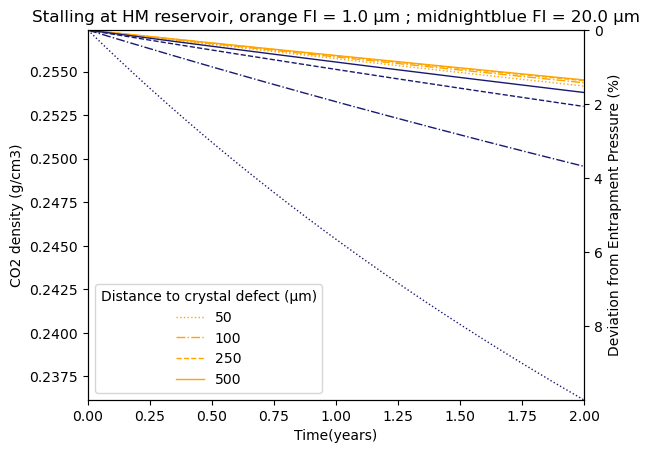

In [11]:
################## Now let's plot our results ######################

time2years=totaltime/years

# Define some constants and variables

y_col = 'CO2_dens_gcm3'
x_col = 'Time(s)'
xlabel4plot = 'Time(years)'
ylabel4plot = 'CO2 density (g/cm3)'
twinlabel4plot = 'Deviation from Entrapment Pressure (%)'
linecolor = 'midnightblue'
linecolor2 = 'orange'
linewidth = 1

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data on the primary y-axis

ax.plot(results_dict['R0']['b0'][x_col] /time2years, results_dict['R0']['b0'][y_col], color=linecolor2, linestyle=':', linewidth=linewidth, label=str(dist2defect_list[0]))
ax.plot(results_dict['R0']['b1'][x_col] /time2years, results_dict['R0']['b1'][y_col], color=linecolor2, linestyle='-.', linewidth=linewidth, label=str(dist2defect_list[1]))
ax.plot(results_dict['R0']['b2'][x_col] /time2years, results_dict['R0']['b2'][y_col], color=linecolor2, linestyle='--', linewidth=linewidth, label=str(dist2defect_list[2]))
ax.plot(results_dict['R0']['b3'][x_col] /time2years, results_dict['R0']['b3'][y_col], color=linecolor2, linestyle='-', linewidth=linewidth, label=str(dist2defect_list[3]))

ax.plot(results_dict['R1']['b0'][x_col] /time2years, results_dict['R1']['b0'][y_col], color=linecolor, linestyle=':', linewidth=linewidth)
ax.plot(results_dict['R1']['b1'][x_col] /time2years, results_dict['R1']['b1'][y_col], color=linecolor, linestyle='-.', linewidth=linewidth)
ax.plot(results_dict['R1']['b2'][x_col] /time2years, results_dict['R1']['b2'][y_col], color=linecolor, linestyle='--', linewidth=linewidth)
ax.plot(results_dict['R1']['b3'][x_col] /time2years, results_dict['R1']['b3'][y_col], color=linecolor, linestyle='-', linewidth=linewidth)

ax2 = ax.twinx()

xlim=([round(min(results_dict['R1']['b0'][x_col]/time2years)),round(max(results_dict['R1']['b0'][x_col]/time2years))])
ymin=np.nanmin([np.nanmin(results_dict['R1']['b0'][y_col])])

ylim=[ymin,fi_rho_initial_gcm3]

ylim_P=pf.calculate_P_for_rho_T(EOS=EOS,CO2_dens_gcm3=pd.Series(ylim),T_K=Trapping_temp+273.15)['P_MPa']

def percent_drop(ylim, original_value):
    return 100-ylim*100/original_value

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax2.set_ylim(percent_drop(ylim_P,original_value=Trapping_pressure*100))

# Customize axis labels and legends
ax.set_title(f"Stalling at HM reservoir, {linecolor2} FI = {round(R_values[0]*10**6,1)} μm ; {linecolor} FI = {round(R_values[1]*10**6,1)} μm")

ax.set_xlabel(xlabel4plot)
ax.set_ylabel(ylabel4plot)
ax2.set_ylabel(twinlabel4plot)

ax.legend(title='Distance to crystal defect (μm)')

